In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import seaborn as sns
import xarray as xr
xr.set_options(display_style='text'); # Show xarray.Dataset representation as text

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10}) # Set plot font size to 16pt

import numpy as np


import os

os.chdir("..")
import pandas as pd


# OPENSENSE Sandbox tools 
# ToDo: Set link from local to github
from Algo2_PWSPYQC_master.Geneve import PWSpyqcFunctions as pws_pyqc
import statsmodels.api as sm
import Funcs as funcs

# Link to the data
main_dir = "Data/"


# Reading Data

In [2]:
# read primary network 1
print('Reading first primary network data')
# pyqc.read_pcp_csv_file has 'latin-1' encoding in PWSpyqcFunctions.py
in_primary_pcp = pws_pyqc.read_pcp_csv_file(path_to_file="Data/Clean_data/oceau_hour_after_april.csv",
                           sep_type=',',
                           index_col=0)

# pyqc uses EPSG:25832, for Netherlands EPSG:28531 is used!
# Reads coordinate file and additionally coverts Lat/Lon to UTM 32
df_prim_coords, prim_coords_xy = pws_pyqc.read_metadata_csv_file("Data/Clean_data/Metadata_oceau.csv",
                                                           sep_type=',', index_col=0,)
df_prim_coords.index = in_primary_pcp.columns
# read pws data
print('Reading PWS data')
df_pws_pcp_hourly = pws_pyqc.read_pcp_csv_file(
        path_to_file="Data/Clean_data/pws_hourly_total.csv",
                           sep_type=',',
                           index_col=0)
    
df_pws_coords, pws_coords_xy = pws_pyqc.read_metadata_csv_file(
        path_to_file="Data/Clean_data/metatablehour_tot.csv",
                           sep_type=',',ID_index =True,
                           index_col=0)


Reading first primary network data
Reading PWS data


In [3]:
meta  = pd.read_csv("Data/Clean_data/metatablehour_tot.csv")

In [12]:
os.getcwd()

'c:\\Users\\arian\\OneDrive\\Documents\\cours\\M1S2\\design_gitlab'

In [13]:
#ce csv est extrait de PWSQC_4.R
slopes_double_cumul = pd.read_csv("Algo1_PWSQC-master/OutputFolder/slopes.csv")
slopes_double_cumul

ID   RawSlope  FilteredSlope
0    05_00_00_00_03_84        NaN            NaN
1    05_00_00_00_04_44   0.894189       1.440205
2    05_00_00_00_0b_98   2.693705       1.236797
3    05_00_00_00_15_46   0.487704            NaN
4    05_00_00_00_15_e6   0.282558       1.092066
..                 ...        ...            ...
260  05_00_00_0b_35_48   1.929951       3.309405
261  05_00_00_0b_45_7c        NaN            NaN
262  05_00_00_0b_67_0c   2.067867       0.587698
263  05_00_00_0b_75_ea  16.160291       3.560183
264  05_00_00_0b_7a_a2        NaN            NaN

[265 rows x 3 columns]

In [14]:
meta["pentes_filtre"] = slopes_double_cumul["FilteredSlope"]
meta["pentes_filtre"].describe()

count    177.000000
mean       1.523536
std        2.154924
min        0.000000
25%        1.079702
50%        1.283993
75%        1.506591
max       21.670288
Name: pentes_filtre, dtype: float64

<Axes: xlabel='altitude', ylabel='pentes_filtre'>

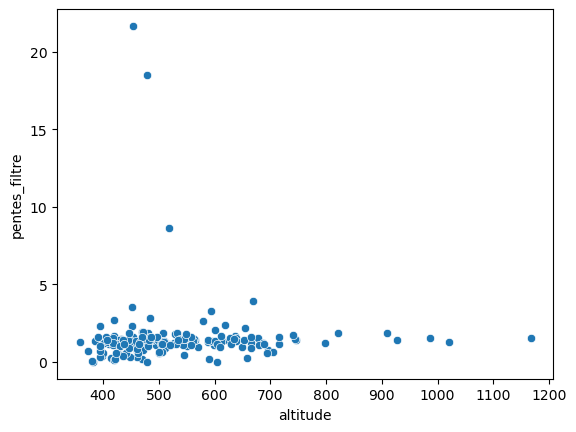

In [15]:
#On veut plot l'altitude face à la pente des doubles cumuls pour voir si il y a un effet orographique
sns.scatterplot(data = meta, x ="altitude",y = "pentes_filtre" )

Il y a quelques valeurs aberrantes de pentes (supérieures à 2,5 ) où il semble que la régression linéaire calculant la pente n'a pas fonctionné. On effectue donc la régression linéaire sur le stations ayant plus de 2 mois de données.

In [16]:
slopes_double_cumul_bis = pd.read_csv("Algo1_PWSQC-master/OutputFolder/slopes_with_2_months.csv")
slopes_double_cumul_bis

ID  RawSlope  FilteredSlope
0    05_00_00_00_03_84       NaN            NaN
1    05_00_00_00_04_44  0.894189       1.440205
2    05_00_00_00_0b_98  2.693705       1.236797
3    05_00_00_00_15_46       NaN            NaN
4    05_00_00_00_15_e6  0.282558       1.092066
..                 ...       ...            ...
260  05_00_00_0b_35_48       NaN            NaN
261  05_00_00_0b_45_7c       NaN            NaN
262  05_00_00_0b_67_0c       NaN            NaN
263  05_00_00_0b_75_ea       NaN            NaN
264  05_00_00_0b_7a_a2       NaN            NaN

[265 rows x 3 columns]

In [17]:
meta["pentes_filtre_with2month"] = slopes_double_cumul_bis["FilteredSlope"]

In [18]:
meta["raw_2_month"] = slopes_double_cumul_bis["RawSlope"]

<Axes: xlabel='altitude', ylabel='pentes_filtre_with2month'>

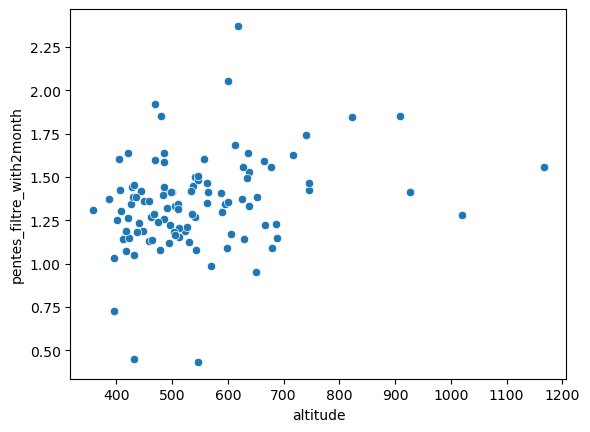

In [19]:
sns.scatterplot(data = meta, x ="altitude",y = "pentes_filtre_with2month" )

# regression linéaire pour voir si il y a un effet significatif de l'altitude sur la pente des doubles cumuls

Coefficient de détermination (R²) : 0.08034829888333561


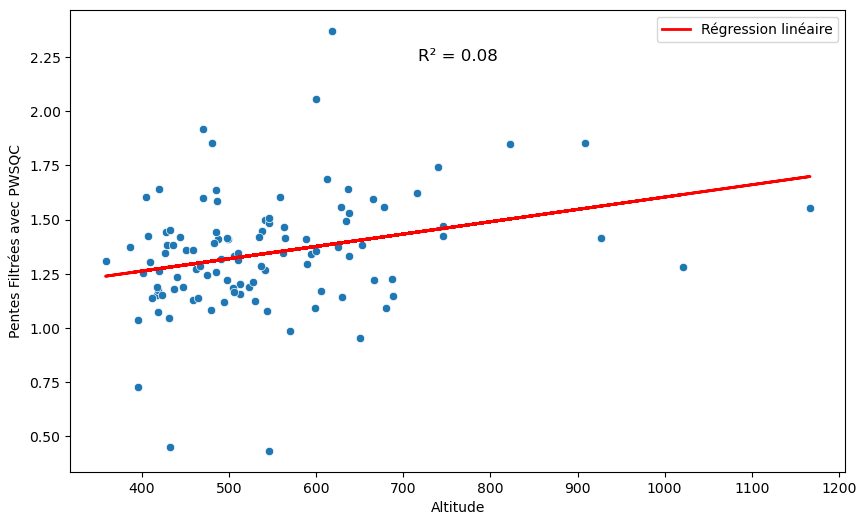

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Création du modèle de régression linéaire
model = LinearRegression()

# Ajustement du modèle sur les données
meta_without_nan = meta.dropna()
X = meta_without_nan["altitude"].values.reshape(-1, 1)
y = meta_without_nan["pentes_filtre_with2month"].values.reshape(-1, 1)
model.fit(X, y)

# Prédiction des valeurs
y_pred = model.predict(X)

# Calcul du R²
r_squared = r2_score(y, y_pred)
print("Coefficient de détermination (R²) :", r_squared)

# Tracé du graphique
plt.figure(figsize=(10, 6))
sns.scatterplot(data=meta, x="altitude", y="pentes_filtre_with2month")
plt.plot(X, y_pred, color='red', linewidth=2, label="Régression linéaire")
plt.xlabel("Altitude")
plt.ylabel("Pentes Filtrées avec PWSQC")
#plt.title("Régression linéaire et R²")

# Ajout du texte R² sur le graphique
plt.text(0.5, 0.9, f'R² = {r_squared:.2f}', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12)

plt.legend()
plt.show()


Coefficient de détermination (R²) : 0.03823827161264426


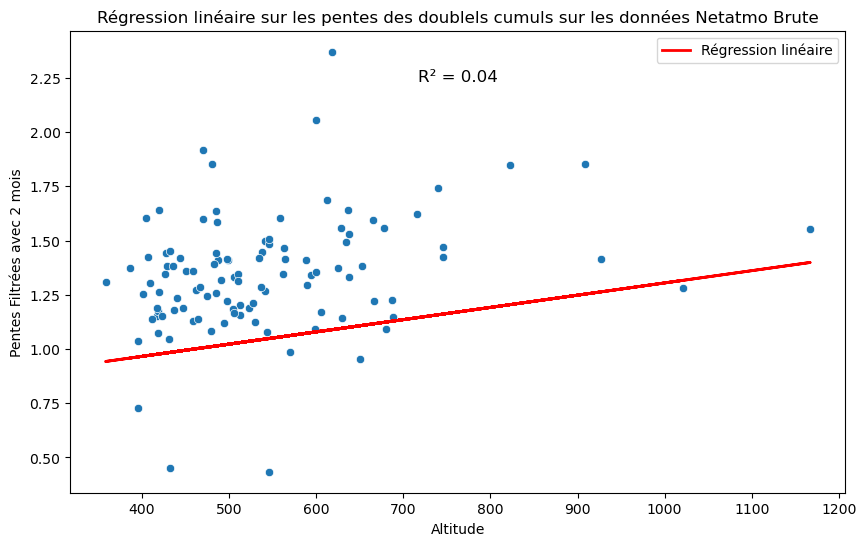

In [21]:
# Création du modèle de régression linéaire
model = LinearRegression()

# Ajustement du modèle sur les données
X = meta_without_nan["altitude"].values.reshape(-1, 1)
y = meta_without_nan["raw_2_month"].values.reshape(-1, 1)
model.fit(X, y)

# Prédiction des valeurs
y_pred = model.predict(X)

# Calcul du R²
r_squared = r2_score(y, y_pred)
print("Coefficient de détermination (R²) :", r_squared)

# Tracé du graphique
plt.figure(figsize=(10, 6))
sns.scatterplot(data=meta, x="altitude", y="pentes_filtre_with2month")
plt.plot(X, y_pred, color='red', linewidth=2, label="Régression linéaire")
plt.xlabel("Altitude")
plt.ylabel("Pentes Filtrées avec 2 mois")
plt.title("Régression linéaire sur les pentes des doublels cumuls sur les données Netatmo Brute")

# Ajout du texte R² sur le graphique
plt.text(0.5, 0.9, f'R² = {r_squared:.2f}', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12)

plt.legend()
plt.show()
